# DS4A: MinJusticia
## Reducing the recidivim risk for people released from jail between 2010 and 2019 <br> 

**Team 77** <br>
**Members:** Sergio Bernal, Wilfer Carvajal , Diego Costa, Laura Goyeneche, Esneyder Guerrero, Daniel Hoyos, Katerin Lopez <br>
**Date:** July, 2020 

## Context

The Ministry of Justice leads the development of public policies that guarantee the effective protection of the rights of their citizens. Currently, the penitentiary and prison entities are interested in characterizing the jail population in Colombia and their recidivism risk to ensure an adequate formulation and monitoring of the criminal policy. <br><br>

## ML objective

Predict the risk of recidivism within X year(s) of their release date for individuals that had been in jail at least once. <br>
*This analysis corresponds to a first approach: we prodicted this risk within 1 year* 

## Basic

In [1]:
# Connect db
from app.backend.utils import DbEngine, Queries
from app.backend.etl import ETL

In [2]:
# Enconding
from app.encoding_module import encoder

In [3]:
# Libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

from sklearn import preprocessing
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, precision_recall_curve, confusion_matrix

%matplotlib inline
plt.style.use('seaborn')

In [4]:
# Import data
inmate = pd.read_excel('data/ReincidenciaPospenadosNal201011Junio2020Rev.xlsx', skiprows = 6)

### Connect to DB

In [5]:
db_engine = DbEngine(user     = 'team77', 
                     password = 'mintic2020.', 
                     ip       = 'localhost', 
                     port     = '5432', 
                     db       = 'minjusticia') 

engine    = db_engine.connect()
queries   = Queries(engine)

### Execute ETL

In [6]:
etl = ETL(queries)
etl.inmate_static_info(inmate)
etl.inmate_variable_info(inmate)

/Users/lauragoyeneche/GitHub/MinJusticia_team77_DS4A_Project/app/backend/etl.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  data_reg['CONDIC_EXPECIONAL'] = data_reg['CONDIC_EXPECIONAL'].fillna('NINGUNO')
/Users/lauragoyeneche/GitHub/MinJusticia_team77_DS4A_Project/app/backend/etl.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  data_reg['madre_gestante'] = 'NA'
/Users/lauragoyeneche/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from 

,crime,min_month,max_month,decree
0,HURTO,16,108,239
1,TRAFICO FABRICACION O PORTE DE ESTUPEFACIENTES,128,360,376
2,FABRICACION TRAFICO Y PORTE DE ARMAS DE FUEGO ...,132,180,366
3,CONCIERTO PARA DELINQUIR,48,108,340
4,HOMICIDIO,208,450,103
5,EXTORSION,192,288,244
6,"FABRICACIÓN, TRÁFICO, PORTE O TENENCIA DE ARMA...",108,144,365
7,VIOLENCIA INTRAFAMILIAR,48,720,229
8,LESIONES PERSONALES,16,360,"[111, 112, 113, 114, 115, 116, 117, 118, 119, ..."
9,FABRICACION TRAFICO Y PORTE DE ARMAS Y MUNICI...,132,180,366


,INTERNOEN,GENERO,DELITO,ESTADO_INGRESO,FECHA_CAPTURA,FECHA_INGRESO,ESTABLECIMIENTO,TENTATIVA,SUBTITULO_DELITO,AGRAVADO,...,ACTIVIDADES_ENSEÑANZA,HIJOS_MENORES,CONDIC_EXPECIONAL,ESTADO,SITUACION_JURIDICA,madre_gestante,madre_lactante,discapacidad,adulto_mayor,crime_score
0,5496C737C624136DB406CFC6744C684C070A3CD8,MASCULINO,FABRICACION TRAFICO Y PORTE DE ARMAS DE FUEGO ...,Intramuros,30/12/09,01/01/10,EPMSC MEDELLIN,N,DE LOS DELITOS DE PELIGRO COMUN O QUE PUEDEN O...,N,...,NO,SI,NINGUNO,Baja,CO,NA,NA,N,N,4


,TENTATIVA,AGRAVADO,CALIFICADO,multiplier
0,N,N,N,2
1,N,S,S,8
2,N,N,S,7
3,N,S,N,6
4,S,S,N,3
5,S,N,N,1
6,S,S,S,5
7,S,N,S,4


/Users/lauragoyeneche/GitHub/MinJusticia_team77_DS4A_Project/app/backend/etl.py:128: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  data_reg['CONSUMADO_b']  = data_reg.TENTATIVA.apply(lambda x: 4 if x=="N" else 0)
/Users/lauragoyeneche/GitHub/MinJusticia_team77_DS4A_Project/app/backend/etl.py:129: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  data_reg['TENTATIVA_b'] = data_reg.TENTATIVA.apply(lambda x: 3 if x=="S" else 0)
/Users/lauragoyeneche/GitHub/MinJusticia_team77_DS4A_Project/app/backend/etl.py:130: SettingWithCopyWarning: 
A value is 

### Encode

In [ ]:
encoding = Encoding(queries)
inmate_df = encoding.get_data()
inmate_df.head()

## Functions

In [4]:
# Featurization 

def reduce_cats(column, max_cat):
    cats = column.value_counts().index.tolist()
    new  = column.map(lambda x: x if x in cats[:max_cat] else 'OTHER')
    return new 

def dummy_helper(column):
    binary = preprocessing.LabelBinarizer()
    x      = column.fillna('MISSING').astype(str)
    temp   = binary.fit_transform(x.values)
    nmes   = [column.name + '_' + i for i in binary.classes_] if temp.shape[1] > 1 else [column.name]
    is_bin = temp.shape[1] == 2
    data   = pd.DataFrame(data = temp, columns = nmes)
    return data, is_bin
    
def binarize(data, column_nme):
    binarized = []
    for nme in column_nme:
        x, is_bin = dummy_helper(data[nme])
        if is_bin:
            data.loc[:,nme] = x
        else:
            data = pd.concat([data, x], axis = 1)
        binarized += list(x.columns)
    return data, binarized

def missing_ind(data, nme_list):
    for nme in nme_list:
        nme_na = 'na_ind_' + nme
        data.loc[:,nme_na] = (data[nme].isnull()).astype(float)
    return data

In [5]:
# Evaluation 
# t: threshold 

def binprob(y_hat, t):
    threshold = np.sort(y_hat)[::-1][int(t*len(y_hat))]
    binary    = [1 if i >= threshold else 0 for i in y_hat]
    y_pred    = np.asarray(binary)
    return y_pred

def accuracy_t(y, y_hat, t):
    y_pred = binprob(y_hat, t)
    score  = accuracy_score(y, y_pred)
    return score 

def precision_t(y, y_hat, t):
    y_pred = binprob(y_hat, t)
    score  = precision_score(y, y_pred)
    return score 

def recall_t(y, y_hat, t):
    y_pred = binprob(y_hat, t)
    score  = recall_score(y, y_pred)
    return score

def plot_precision_recall(y, y_hat, title = None):

    precision_curve, recall_curve, pr_threshold = precision_recall_curve(y, y_hat)
    precision_curve = precision_curve[:-1]
    recall_curve    = recall_curve[:-1]
    
    above_threshold = []
    number_scored   = len(y_hat)
    
    for value in pr_threshold:
        num_above_thresh = len(y_hat[y_hat >= value])
        pct_above_thresh = num_above_thresh/float(number_scored)
        above_threshold.append(pct_above_thresh)
    
    above_threshold = np.array(above_threshold)
    
    fig = plt.figure(figsize = (4,3))
    ax1 = fig.add_subplot(111)
    ax1.plot(above_threshold, precision_curve, 'b')
    ax1.set_xlabel('\nFraction of Population')
    ax1.set(ylim = (0, 1))

    ax1.set_ylabel('Precision\n', color = 'b')
    ax2 = ax1.twinx()
    ax1.plot(above_threshold, recall_curve, 'r')
    ax2.set_ylabel('Recall\n', color = 'r')
    
    if title is not None:
        plt.title(title + '\n')
    
    plt.show()

## Feature Engineering

In [6]:
# Feature changes
# Dates
inmate.FECHA_INGRESO = pd.to_datetime(inmate.FECHA_INGRESO)
inmate.FECHA_SALIDA  = pd.to_datetime(inmate.FECHA_SALIDA)
inmate.FECHA_CAPTURA = pd.to_datetime(inmate.FECHA_CAPTURA)

# Crime types
inmate.TENTATIVA  = inmate.TENTATIVA .apply(lambda x: 1 if x == 'S' else 0)
inmate.AGRAVADO   = inmate.AGRAVADO  .apply(lambda x: 1 if x == 'S' else 0)
inmate.CALIFICADO = inmate.CALIFICADO.apply(lambda x: 1 if x == 'S' else 0)

inmate.TENTATIVA  = inmate.TENTATIVA .apply(lambda x: 'TENT_' if x == 1 else '')
inmate.AGRAVADO   = inmate.AGRAVADO  .apply(lambda x: 'AGRA_' if x == 1 else '')
inmate.CALIFICADO = inmate.CALIFICADO.apply(lambda x: 'CALF_' if x == 1 else '')

# Activities
inmate.ACTIVIDADES_TRABAJO   = inmate.ACTIVIDADES_TRABAJO  .apply(lambda x: 1 if x == 'SI' else 0)
inmate.ACTIVIDADES_ESTUDIO   = inmate.ACTIVIDADES_ESTUDIO  .apply(lambda x: 1 if x == 'SI' else 0)
inmate.ACTIVIDADES_ENSEÑANZA = inmate.ACTIVIDADES_ENSEÑANZA.apply(lambda x: 1 if x == 'SI' else 0)

# Children: Y/N
inmate.HIJOS_MENORES = inmate.HIJOS_MENORES.apply(lambda x: 1 if x == 'SI' else 0)

# Genero
inmate.GENERO = inmate.GENERO.apply(lambda x: 1 if x == 'MASCULINO' else 0)

# Crime + crime type
inmate['DELITO_COMP'] = inmate.TENTATIVA + inmate.AGRAVADO + inmate.CALIFICADO + inmate.DELITO
inmate.DELITO_COMP    = reduce_cats(inmate.DELITO_COMP, 20)

# Country 
inmate.PAIS_INTERNO = reduce_cats(inmate.PAIS_INTERNO, 2)

In [7]:
# Select features of interest
inmate = inmate[['INTERNOEN',
                 'DELITO_COMP',
                 'FECHA_INGRESO','FECHA_SALIDA','FECHA_CAPTURA',
                 'ANO_NACIMIENTO','GENERO','ESTADO_CIVIL','NIVEL_EDUCATIVO','HIJOS_MENORES',
                 'PAIS_INTERNO',
                 'ESTADO_INGRESO',
                 'ACTIVIDADES_TRABAJO','ACTIVIDADES_ESTUDIO','ACTIVIDADES_ENSEÑANZA',
                 'DEPTO_ESTABLECIMIENTO','REGIONAL']]

In [8]:
# Intermediate table
iscat  = [nme for nme in inmate.columns[inmate.dtypes == 'object'] if nme != 'INTERNOEN']
inmate = binarize(inmate, iscat)[0]
inmate = inmate.drop(iscat, axis = 1)
inmate = inmate.drop(['FECHA_CAPTURA'], axis = 1)

In [9]:
# Time in jail 
inmate['timejail_day'] = (inmate.FECHA_SALIDA - inmate.FECHA_INGRESO)
inmate.timejail_day    = inmate.timejail_day.dt.days

## Master table

In [10]:
# Key: inmate + booking date
inmate_booking = inmate.copy().sort_values(by = ['INTERNOEN','FECHA_INGRESO'])\
                              .groupby(['INTERNOEN','FECHA_INGRESO'])\
                              .max()\
                              .reset_index()

In [11]:
# Recidivism in days and booking data t-1
inmate_booking['FECHA_SALIDA_t_1'] = inmate_booking.groupby('INTERNOEN').FECHA_SALIDA.shift(1)
inmate_booking['recidivism_day']   = (inmate_booking.FECHA_INGRESO - inmate_booking.FECHA_SALIDA_t_1).dt.days

In [12]:
# Year booking date 
inmate_booking['year'] = inmate_booking.FECHA_INGRESO.dt.year

## Handling NAs and errors

Below we can observe that there is a large number of observations without `time in jail` and `recidivism in days`. The main reason is that the ministry of Justice didn't gave the DS4A team access to data of the the first time in jail for all inmates between 2010 and 2019. As well, due to errors in the data, when comparing the release date in t-1 and booking date in t, we have negative values. For this reasons we decided that the best way to deal with NAs is to impute those values based on the distribution of the observables values. We argue that this is plausible given that the literature and the recidivism in other countries present the same trend as the one from our observable values, by imputing those values on the distribution. For negative values of `time in jail` and `recividism in days` we omit them.

In [13]:
# Columns with NA values
inmate_booking.columns[inmate_booking.isna().any()].tolist()

['FECHA_SALIDA', 'timejail_day', 'FECHA_SALIDA_t_1', 'recidivism_day']

In [14]:
# Identify NAs from our features of interest
print('Total inmates and booking date {}'.format(inmate_booking.shape[0]))
print('Time in jail in days NAs are {}'  .format(inmate_booking.timejail_day.isna().sum()))
print('Recidivism in days NAs are {}'    .format(inmate_booking.recidivism_day.isna().sum()))

Total inmates and booking date 103290
Time in jail in days NAs are 30304
Recidivism in days NAs are 78857


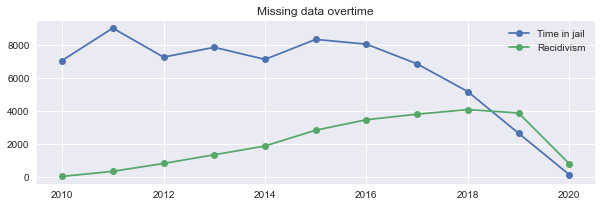

In [15]:
# Understand NAs overtime
# Time in jail and recidivism in days
plt.figure(figsize = (10,3))
plt.plot(inmate_booking[inmate_booking.timejail_day   > 0].groupby('year').count().INTERNOEN.to_frame().rename(columns = {'INTERNOEN':'NA_count'}), '-o', label = 'Time in jail')
plt.plot(inmate_booking[inmate_booking.recidivism_day > 0].groupby('year').count().INTERNOEN.to_frame().rename(columns = {'INTERNOEN':'NA_count'}), '-o', label = 'Recidivism')
plt.title('Missing data overtime')
plt.legend()
plt.show()

In [16]:
# Summary of statistics for time in jail and recividism 
stats = inmate_booking[(inmate_booking.recidivism_day > 0) & (inmate_booking.timejail_day > 0)][['recidivism_day','timejail_day']].describe()
stats

,recidivism_day,timejail_day
count,17263.000000,17263.000000
mean,758.160517,551.920640
std,599.162070,415.245575
min,1.000000,1.000000
25%,294.000000,246.000000
50%,605.000000,458.000000
75%,1085.000000,749.000000
max,5311.000000,2967.000000


In [17]:
# Impute recidivism and time in jail 
# Methodology: conditional imputation with 10 iterations (default)
df_imp     = inmate_booking.drop(columns = ['FECHA_INGRESO','FECHA_SALIDA','FECHA_SALIDA_t_1','INTERNOEN'])
imp_mean   = IterativeImputer(random_state = 0, max_iter = 10, add_indicator = True, skip_complete = True)
inmate_imp = imp_mean.fit_transform(df_imp)
inmate_imp = pd.DataFrame(inmate_imp, columns = df_imp.columns.tolist() + ['imp_timejail','imp_recidivism'])

In [18]:
# Replace imputed values
inmate_booking.recidivism_day    = inmate_imp.recidivism_day
inmate_booking.timejail_day      = inmate_imp.timejail_day
inmate_booking['imp_recidivism'] = inmate_imp.imp_recidivism
inmate_booking['imp_timejail']   = inmate_imp.imp_timejail

In [19]:
# Identify negative values from our features of interest
print('Total inmates and booking date {}'   .format(inmate_booking.shape[0]))
print('Time in jail in days negative are {}'.format((inmate_booking.timejail_day < 0).sum()))
print('Recidivism in days negative are {}'  .format((inmate_booking.recidivism_day < 0).sum()))

Total inmates and booking date 103290
Time in jail in days negative are 6656
Recidivism in days negative are 5331


In [20]:
# Delete negative values from time in jail and recidivism 
inmate_booking = inmate_booking[inmate_booking.timejail_day   >= 0] # omit 3041
inmate_booking = inmate_booking[inmate_booking.recidivism_day >= 0] # omit 841

In [21]:
# Final master table dimension 
print('Total inmates and booking date {}'.format(inmate_booking.shape[0]))

Total inmates and booking date 91350


In [22]:
# Additional columns with missing values
inmate_booking.columns[inmate_booking.isnull().any()].tolist()

['FECHA_SALIDA', 'FECHA_SALIDA_t_1']

## Modeling

### Train and test sets

In [23]:
# Split data based on time
train_start = 2010
train_end   = 2017
test_start  = 2018
test_end    = 2019

In [24]:
# Generate train and test data frames
dftrain = inmate_booking.copy()[(inmate_booking.year >= train_start) & (inmate_booking.year <= train_end)]
dftest  = inmate_booking.copy()[(inmate_booking.year >= test_start ) & (inmate_booking.year <= test_end )]

# Calculate age based on train and test end period
dftrain['age'] = train_end - dftrain.ANO_NACIMIENTO
dftest['age']  = test_end  - dftest .ANO_NACIMIENTO

# Calculate outcome variable = 1 if individual came to jail in less that a year
dftrain['outcome'] = (dftrain.recidivism_day <= 12*30).astype(int)
dftest['outcome']  = (dftest.recidivism_day  <= 12*30).astype(int)

In [25]:
# Number of individuals that came back to jail in less than a year
print('Train set: {} out of {} ~ {}%'.format(dftrain.outcome.sum(),dftrain.shape[0],round(dftrain.outcome.sum()*100/dftrain.shape[0])))
print('Test  set: {} out of {} ~ {}%'.format(dftest.outcome.sum(),dftest.shape[0],round(dftest.outcome.sum()*100/dftest.shape[0])))

Train set: 16736 out of 66592 ~ 25.0%
Test  set: 1746 out of 22846 ~ 8.0%


In [26]:
colnmes = dftrain.columns.drop(['ANO_NACIMIENTO','FECHA_SALIDA_t_1','FECHA_INGRESO','FECHA_SALIDA','INTERNOEN','year','recidivism_day','outcome']).tolist()

In [27]:
X_train, y_train = dftrain[colnmes], dftrain['outcome']
X_test , y_test  = dftest [colnmes], dftest ['outcome']

### Modeling

In [28]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors    import KNeighborsClassifier
from sklearn.tree         import DecisionTreeClassifier
from sklearn.ensemble     import RandomForestClassifier
from sklearn.naive_bayes  import GaussianNB

In [29]:
from warnings import filterwarnings
filterwarnings('ignore')

In [30]:
# Define models
models = dict()
models['LR' ] = LogisticRegression()
models['KNN'] = KNeighborsClassifier()
models['DT' ] = DecisionTreeClassifier()
models['RF' ] = RandomForestClassifier(random_state = 10)
models['NB' ] = GaussianNB()

In [31]:
# Define paameters for GridSearch
params = dict()
params['LR' ] = {'penalty'    : ['l1','l2'], 'C': [0.8, 1.0], 'solver': ['saga']}
params['KNN'] = {'n_neighbors': [3, 5, 10], 'weights': ['uniform','distance'], }
params['DT' ] = {'max_depth'  : [3, 6 ], 'max_features': [4, 8, 20]}
params['RF' ] = {'max_depth'  : [5, 20], 'max_features': ['auto','sqrt','log2'], 'min_samples_leaf': [1,2,4]}
params['NB' ] = {}

In [32]:
# GridSearch
results = dict()
for name in models.keys():
    mcv = GridSearchCV(estimator = models[name], param_grid = params[name], cv = 5, n_jobs = -1)
    mcv.fit(X_train, y_train)
    results[name] = mcv.best_estimator_
    print(name)

LR
KNN
DT
RF
NB


### Testing

In [33]:
# Yhat for each model
y_pred = dict()
for name in results.keys():
    y_pred[name] = results[name].predict_proba(X_test)
    
# Values from ytest
y_true = y_test.values

In [34]:
# Tests metrics on 20% of the population
# Assumption: Ministry of Justica with limited resources to implement policies on 100% of the individuals
k = 0.2 

pd.DataFrame({'Accuracy' : [accuracy_t (y_test, y_pred[name][:,1], k) for name in y_pred.keys()],
              'Precision': [precision_t(y_test, y_pred[name][:,1], k) for name in y_pred.keys()],
              'Recall'   : [recall_t   (y_test, y_pred[name][:,1], k) for name in y_pred.keys()]}, 
            index = models.keys())

,Accuracy,Precision,Recall
LR,0.808194,0.211597,0.553837
KNN,0.687341,0.156461,0.703895
DT,0.837346,0.284464,0.744559
RF,0.858268,0.336761,0.881443
NB,0.795238,0.179212,0.469072


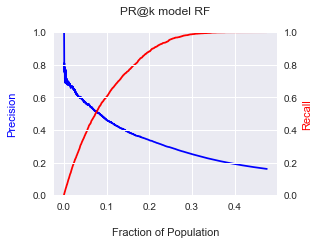

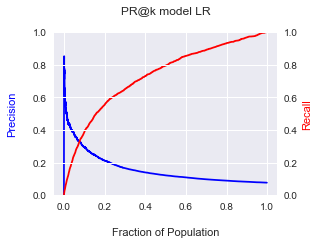

In [35]:
# Precision-Recall @k
plot_precision_recall(y_test, y_pred['RF'][:,1], 'PR@k model {}'.format('RF'))
plot_precision_recall(y_test, y_pred['LR'][:,1], 'PR@k model {}'.format('LR'))

### Feature importance

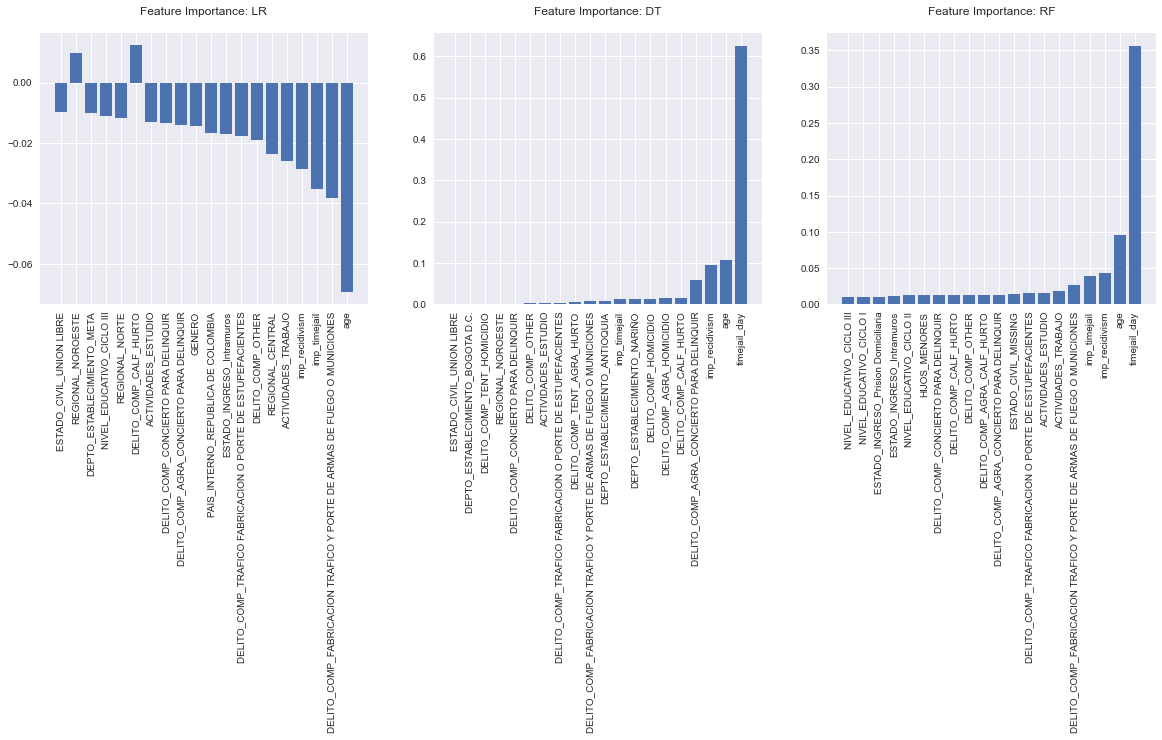

In [36]:
# Number of features
n = 20

# Plot
plt.figure(figsize = (20,5))
for i, name in enumerate(['LR','DT','RF']):
    features  = X_train.columns
    
    if name == 'LR':
        important = results['LR'].coef_[0]
        idxs      = np.argsort(abs(important))[-n:]
    else: 
        important = results[name].feature_importances_
        idxs      = np.argsort(important)[-n:]

    plt.subplot(1,3,i+1)
    plt.bar(range(len(idxs)), important[idxs])
    plt.xticks(range(len(idxs)), [features[i] for i in idxs], rotation = 90)
    plt.title('Feature Importance: {}\n'.format(name))

plt.show()